### Testing out some plotting code for single unit plots, PSTH + raster

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
import utils.anova_utils as anova_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

In [3]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
turbo = cm.get_cmap('turbo', 6)  # sample 5 discrete colors
colors = [turbo(i) for i in range(turbo.N)]
hex_colors = [mcolors.to_hex(c) for c in colors]


/tmp/ipykernel_366524/1133329301.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo = cm.get_cmap('turbo', 6)  # sample 5 discrete colors


In [4]:
hex_colors

['#30123b', '#3e9bfe', '#46f884', '#e1dd37', '#f05b12', '#7a0403']

In [5]:
mode = "pref"
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
if mode in ["choice", "reward"]:
    args.conditions = ["Choice", "Response"]
    args.beh_filters = {}
else: 
    args.conditions = ["BeliefConf", "BeliefPartition"]
    args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

args.window_size = 500
args.sig_thresh = "99th"

In [6]:
mode_to_cond = {
    "pref": "BeliefPref",
    "conf": "BeliefConf",
    "choice": "Choice",
    "reward": "Response"
}

In [7]:
args.trial_event = "StimOnset"
stim_res = io_utils.read_anova_good_units(args, "99th", mode_to_cond[mode], return_pos=True)
stim_res["trial_event"] = args.trial_event
args.trial_event = "FeedbackOnsetLong"
fb_res = io_utils.read_anova_good_units(args, "99th", mode_to_cond[mode], return_pos=True)
fb_res["trial_event"] = args.trial_event

all_res = pd.concat((stim_res, fb_res))
# io_utils.read_anova_good_units(args, args.sig_thresh, "BeliefPref", return_pos=True)


In [8]:
stim_res.structure_level2_cleaned.unique()

array(['primary_visual_cortex_V1', 'lateral_prefrontal_cortex_lat_PFC',
       'anterior_cingulate_gyrus_ACgG', 'orbital_frontal_cortex_OFC',
       'motor_cortex_motor', 'amygdala_Amy',
       'inferior_temporal_cortex_ITC', 'superior_parietal_lobule_SPL',
       'medial_pallium_MPal', 'basal_ganglia_BG',
       'inferior_parietal_lobule_IPL', 'posterior_medial_cortex_PMC',
       'lateral_and_ventral_pallium_LVPal', 'thalamus_Thal',
       'floor_of_the_lateral_sulcus_floor_of_ls',
       'extrastriate_visual_areas_2-4_V2-V4',
       'core_and_belt_areas_of_auditory_cortex_core/belt',
       'somatosensory_cortex_SI/SII', 'medial_temporal_lobe_MTL',
       'unknown', 'preoptic_complex_POC'], dtype=object)

In [9]:
def get_sig_levels(row, cond):
    col_name = f"x_{cond}_comb_time_fracvar"
    if row[col_name] > row[f"{cond}_99th"]:
        return "99th"
    elif row[col_name] > row[f"{cond}_95th"]:
        return "95th"
    else:
        return "insignificant"
    
    
all_res["p"] = all_res.apply(lambda x: get_sig_levels(x, mode_to_cond[mode]), axis=1)
all_res["Time"] = all_res.WindowEndMilli / 1000 - 0.25 # the middle of the 500ms window

In [10]:
all_res.p.unique()

array(['insignificant', '99th', '95th'], dtype=object)

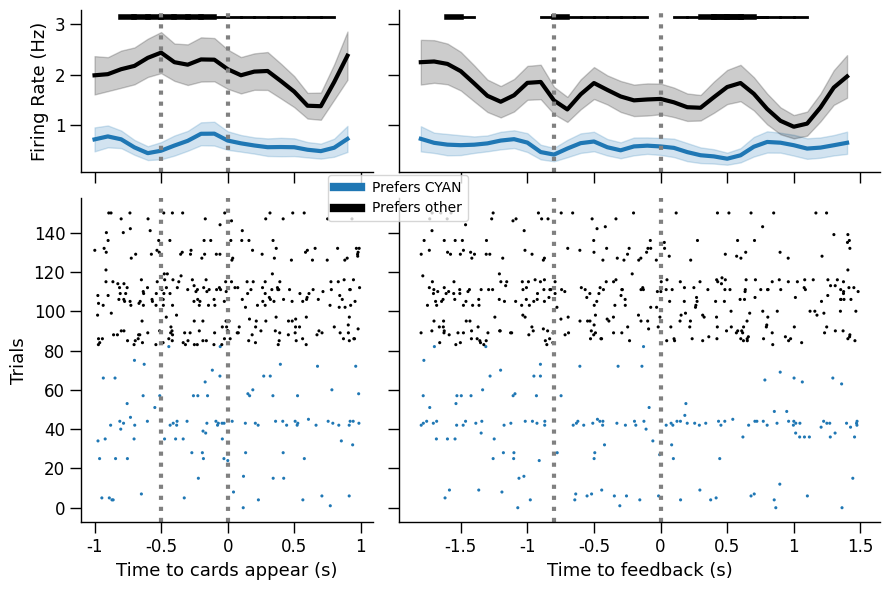

In [14]:
region_res = all_res[all_res.structure_level2 == "lateral_prefrontal_cortex (lat_PFC)"]
col_name = f"x_{mode_to_cond[mode]}_comb_time_fracvar"
summed = region_res.groupby(["PseudoUnitID", "feat"])[col_name].sum().reset_index()
top = summed.sort_values(col_name, ascending=False).drop_duplicates('PseudoUnitID').head(1)

for i, row in top.iterrows():
    fig, axs = visualization_utils.plot_psth_both_events(mode, int(row.PseudoUnitID), row.feat, args, all_res)
    # fig.suptitle(f"{row.PseudoUnitID}, {row.feat}")


### Code to find the best units: 
- grab results for both trial events, StimOnset, FbOnset
- filter by region
- per unit, feature, sum of frac var explained across all time points
- 

In [52]:
region_res.columns

Index(['PseudoUnitID', 'total_var', 'x_TimeBins_fracvar', 'x_Choice_fracvar',
       'x_Response_fracvar', 'x_TimeBinsChoice_fracvar',
       'x_TimeBinsResponse_fracvar', 'x_ChoiceResponse_fracvar',
       'x_TimeBinsChoiceResponse_fracvar', 'residual_fracvar', 'sum_fracvar',
       'x_Choice_comb_time_fracvar', 'x_Response_comb_time_fracvar',
       'x_ChoiceResponse_comb_time_fracvar', 'feat', 'WindowStartMilli',
       'WindowEndMilli', 'Choice_95th', 'Choice_99th', 'Response_95th',
       'Response_99th', 'ChoiceResponse_95th', 'ChoiceResponse_99th', 'drive',
       'structure_level2', 'whole_pop', 'trial_event'],
      dtype='object')

In [60]:
summed = region_res.groupby(["PseudoUnitID", "feat"]).x_Response_comb_time_fracvar.sum().reset_index()
top5 = summed.sort_values('x_Response_comb_time_fracvar', ascending=False).drop_duplicates('PseudoUnitID').head(5)


In [62]:
top5

,PseudoUnitID,feat,x_Response_comb_time_fracvar
624,2018100414,POLKADOT,3.915460
655,2018100510,RIPPLE,3.814565
603,2018100312,CYAN,3.768135
499,2018092814,SQUARE,3.518952
577,2018100216,SQUARE,3.334176
